Working File for ResNet50

In [1]:
# === Data / Dataloaders for ResNet-50 (baseline, no RandAug) ===

import os, csv
from pathlib import Path
from PIL import Image

import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

# Paths
CSV_DIR    = Path(r"C:\Users\Andre\Documents\Machine Learning Project\processed_csvs")
IMAGE_ROOT = CSV_DIR  # images live under this root

# Label mapping (keep consistent across all models)
LABEL_TO_IDX = {"clear": 0, "obstructed": 1}

# ImageNet normalization (same as other models)
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])

def get_transforms():
    """Baseline transforms for ResNet-50 (NO RandAug)."""
    train_tf = transforms.Compose([
        transforms.Resize(256),
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        normalize,
    ])

    eval_tf = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        normalize,
    ])
    return train_tf, eval_tf

train_tf, eval_tf = get_transforms()


class CSVDataset(Dataset):
    def __init__(self, csv_path, transform, image_root=None):
        self.rows = []
        self.transform = transform
        self.image_root = image_root

        with open(csv_path, "r", newline="") as f:
            r = csv.DictReader(f)
            assert {"filename","label"}.issubset(r.fieldnames), f"Missing headers in {csv_path}"
            for row in r:
                fp = row["filename"].strip()
                if image_root is not None and not os.path.isabs(fp):
                    fp = str(Path(image_root) / fp)
                lab = row["label"].strip().lower()
                assert lab in LABEL_TO_IDX, f"Unknown label {lab} in {csv_path}"
                self.rows.append((fp, LABEL_TO_IDX[lab]))

    def __len__(self):
        return len(self.rows)

    def __getitem__(self, idx):
        img_path, y = self.rows[idx]
        with Image.open(img_path) as im:
            im = im.convert("RGB")
        x = self.transform(im)
        return x, torch.tensor(y, dtype=torch.long)


def make_loaders(batch_size=64, num_workers=0, pin_memory=True):
    train_csv = CSV_DIR / "train.csv"
    val_csv   = CSV_DIR / "val.csv"
    test_csv  = CSV_DIR / "test.csv"

    train_ds = CSVDataset(train_csv, transform=train_tf, image_root=IMAGE_ROOT)
    val_ds   = CSVDataset(val_csv,   transform=eval_tf,  image_root=IMAGE_ROOT)
    test_ds  = CSVDataset(test_csv,  transform=eval_tf,  image_root=IMAGE_ROOT)

    train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True,
                              num_workers=num_workers, pin_memory=pin_memory)
    val_loader   = DataLoader(val_ds,   batch_size=batch_size, shuffle=False,
                              num_workers=num_workers, pin_memory=pin_memory)
    test_loader  = DataLoader(test_ds,  batch_size=batch_size, shuffle=False,
                              num_workers=num_workers, pin_memory=pin_memory)

    return train_loader, val_loader, test_loader, train_ds, val_ds, test_ds


# Quick sanity check
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
train_loader, val_loader, test_loader, train_ds, val_ds, test_ds = make_loaders(
    batch_size=64,
    num_workers=0,   # safest in Jupyter on Windows
    pin_memory=True
)

print("Label mapping:", LABEL_TO_IDX)
print("Train size:", len(train_ds), "Val size:", len(val_ds), "Test size:", len(test_ds))

xb, yb = next(iter(train_loader))
print("Batch x shape:", xb.shape)       # [B, 3, 224, 224]
print("Batch y shape:", yb.shape)       # [B]
print("Unique labels in batch:", sorted(set(yb.tolist())))
print("Device available:", device)


Label mapping: {'clear': 0, 'obstructed': 1}
Train size: 14000 Val size: 3000 Test size: 3000
Batch x shape: torch.Size([64, 3, 224, 224])
Batch y shape: torch.Size([64])
Unique labels in batch: [0, 1]
Device available: cuda


In [ ]:
# === Training ResNet-50 (baseline, no RandAug) ===

import time
import torch
import torch.nn as nn
from torchvision import models

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
NUM_CLASSES = 2  # clear / obstructed


def run_one_epoch(model, loader, criterion, optimizer, scaler, train=True):
    model.train(train)
    total, correct, loss_sum = 0, 0, 0.0
    t0 = time.time()

    for xb, yb in loader:
        xb, yb = xb.to(device, non_blocking=True), yb.to(device, non_blocking=True)

        if train:
            optimizer.zero_grad(set_to_none=True)

        with torch.autocast(device_type="cuda", enabled=(device.type == "cuda")):
            logits = model(xb)
            loss = criterion(logits, yb)

        if train:
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()

        loss_sum += loss.item() * yb.size(0)
        pred = logits.argmax(1)
        correct += (pred == yb).sum().item()
        total   += yb.size(0)

    dt = time.time() - t0
    return loss_sum / total, correct / total, dt


def train_resnet50():
    # 1) Data
    train_loader, val_loader, _, _, _, _ = make_loaders(
        batch_size=64,
        num_workers=0,
        pin_memory=True
    )

    # 2) Model (ImageNet pretrained ResNet-50)
    model = models.resnet50(weights=models.ResNet50_Weights.DEFAULT)
    in_feats = model.fc.in_features
    model.fc = nn.Linear(in_feats, NUM_CLASSES)
    model = model.to(device)

    # 3) Loss / Optimizer / Scheduler / AMP
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.AdamW(model.parameters(), lr=3e-4, weight_decay=1e-4)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode="max", factor=0.5, patience=2
    )
    scaler = torch.amp.GradScaler("cuda", enabled=(device.type == "cuda"))

    # 4) Train loop
    EPOCHS = 8
    best_val = 0.0
    best_path = "resnet50_clear_obstructed_best.pt"  # matches your existing file

    for epoch in range(1, EPOCHS + 1):
        tr_loss, tr_acc, tr_dt = run_one_epoch(
            model, train_loader, criterion, optimizer, scaler, train=True
        )
        va_loss, va_acc, va_dt = run_one_epoch(
            model, val_loader,   criterion, optimizer, scaler, train=False
        )

        scheduler.step(va_acc)

        print(f"epoch {epoch:02d} | "
              f"train: loss {tr_loss:.4f} acc {tr_acc:.3f} ({tr_dt:.1f}s) | "
              f"val:   loss {va_loss:.4f} acc {va_acc:.3f} ({va_dt:.1f}s) | "
              f"lr: {optimizer.param_groups[0]['lr']:.2e}")

        if va_acc > best_val:
            best_val = va_acc
            torch.save(model.state_dict(), best_path)
            print(f"  ⮕ saved best to {best_path} (val_acc={best_val:.3f})")

    print("Training done. Best val_acc:", f"{best_val:.3f}")
    return best_path, best_val


# Optional: only run if you need to retrain
# best_path_resnet50, best_val_resnet50 = train_resnet50()


In [2]:
# === Evaluation of ResNet-50 on Test Set (baseline) ===

import torch
import torch.nn as nn
from torchvision import models

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


def eval_resnet50_checkpoint(best_weights_path):
    # Rebuild model with same head shape as training
    model = models.resnet50(weights=models.ResNet50_Weights.DEFAULT)
    in_feats = model.fc.in_features
    model.fc = nn.Linear(in_feats, 2)

    model.load_state_dict(torch.load(best_weights_path, map_location=device))
    model.to(device)
    model.eval()

    cm = torch.zeros(2, 2, dtype=torch.long)  # rows=true, cols=pred
    total, correct = 0, 0

    with torch.no_grad():
        for xb, yb in test_loader:  # test_loader from data cell
            xb, yb = xb.to(device), yb.to(device)
            logits = model(xb)
            pred = logits.argmax(1)

            for t, p in zip(yb.view(-1), pred.view(-1)):
                cm[t.long(), p.long()] += 1

            correct += (pred == yb).sum().item()
            total   += yb.size(0)

    acc = correct / total

    TN, FP = cm[0,0].item(), cm[0,1].item()
    FN, TP = cm[1,0].item(), cm[1,1].item()

    def safe_div(a, b): return a / b if b > 0 else 0.0

    # metrics for clear (class 0)
    prec_clear = safe_div(TN, TN + FN)
    rec_clear  = safe_div(TN, TN + FP)
    f1_clear   = safe_div(
        2 * prec_clear * rec_clear,
        prec_clear + rec_clear
    ) if (prec_clear + rec_clear) > 0 else 0.0

    # metrics for obstructed (class 1)
    prec_obst = safe_div(TP, TP + FP)
    rec_obst  = safe_div(TP, TP + FN)
    f1_obst   = safe_div(
        2 * prec_obst * rec_obst,
        prec_obst + rec_obst
    ) if (prec_obst + rec_obst) > 0 else 0.0

    print("Test accuracy:", f"{acc:.3f}")
    print("Confusion matrix (rows=true, cols=pred):")
    print(cm.tolist())
    print("Per-class metrics:")
    print(f"  clear (0):       precision {prec_clear:.3f}  recall {rec_clear:.3f}  f1 {f1_clear:.3f}")
    print(f"  obstructed (1):  precision {prec_obst:.3f}  recall {rec_obst:.3f}  f1 {f1_obst:.3f}")

    return acc, cm, {
        "clear":      (prec_clear, rec_clear, f1_clear),
        "obstructed": (prec_obst, rec_obst, f1_obst),
    }


# Use your existing checkpoint:
acc_r50, cm_r50, metrics_r50 = eval_resnet50_checkpoint(
    "resnet50_clear_obstructed_best.pt"
)


C:\Users\Andre\AppData\Local\Temp\ipykernel_33700\1195907679.py:16: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(best_weights_path, map_loc

Test accuracy: 0.918
Confusion matrix (rows=true, cols=pred):
[[1584, 145], [101, 1170]]
Per-class metrics:
  clear (0):       precision 0.940  recall 0.916  f1 0.928
  obstructed (1):  precision 0.890  recall 0.921  f1 0.905


In [3]:
# === Latency & Throughput — ResNet-50 ===

import time
import numpy as np
import torch
import torch.nn as nn
from torchvision import models

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
NUM_CLASSES = 2

# Change this ONLY when you want to test a different ResNet-50 checkpoint
R50_BEST_WEIGHTS = r"C:\Users\Andre\Documents\Machine Learning Project\resnet50_clear_obstructed_best.pt"


@torch.no_grad()
def benchmark(model, loader, warmup=20, iters=200):
    model.eval()

    # Grab one single-image batch and one full batch from the loader
    xb1, _ = next(iter(loader))
    xb1 = xb1[:1].to(device)   # [1, 3, 224, 224]
    xbB, _ = next(iter(loader))
    xbB = xbB.to(device)       # [B, 3, 224, 224]

    times_single, times_batch = [], []

    # ---- warmup ----
    for _ in range(warmup):
        with torch.autocast(device_type="cuda", enabled=(device.type == "cuda")):
            _ = model(xb1)
            _ = model(xbB)
    if device.type == "cuda":
        torch.cuda.synchronize()

    # ---- single-image timing ----
    for _ in range(iters):
        t0 = time.perf_counter()
        with torch.autocast(device_type="cuda", enabled=(device.type == "cuda")):
            _ = model(xb1)
        if device.type == "cuda":
            torch.cuda.synchronize()
        times_single.append(time.perf_counter() - t0)

    # ---- batch timing (throughput) ----
    for _ in range(iters):
        t0 = time.perf_counter()
        with torch.autocast(device_type="cuda", enabled=(device.type == "cuda")):
            _ = model(xbB)
        if device.type == "cuda":
            torch.cuda.synchronize()
        times_batch.append(time.perf_counter() - t0)

    def stats(ts):
        ts = np.array(ts) * 1000.0  # seconds → ms
        return ts.mean(), np.percentile(ts, 95)

    m1, p951 = stats(times_single)
    mB, p95B = stats(times_batch)
    bsz = xbB.size(0)

    fps_single = 1000.0 / m1
    fps_batch  = (bsz * 1000.0) / mB

    return (m1, p951, fps_single), (mB, p95B, fps_batch), bsz


def benchmark_resnet50(weights_path: str):
    """
    Build ResNet-50 with a 2-class head, load weights from `weights_path`,
    and benchmark latency & throughput using the existing `test_loader`.
    """
    global test_loader  # uses the test_loader created in the data/dataloaders cell

    model = models.resnet50(weights=None)
    in_feats = model.fc.in_features
    model.fc = nn.Linear(in_feats, NUM_CLASSES)

    model.load_state_dict(torch.load(weights_path, map_location=device))
    model.to(device)

    (m1, p951, fps1), (mB, p95B, fpsB), bsz = benchmark(model, test_loader)

    print(f"Checkpoint: {weights_path}")
    print(f"Single image:  mean {m1:.2f} ms  p95 {p951:.2f} ms  FPS ~{fps1:.1f}")
    print(f"Batch ({bsz}): mean {mB:.2f} ms  p95 {p95B:.2f} ms  Throughput ~{fpsB:.1f} img/s")

    return {
        "weights": weights_path,
        "single_mean_ms": m1,
        "single_p95_ms": p951,
        "single_fps": fps1,
        "batch_mean_ms": mB,
        "batch_p95_ms": p95B,
        "batch_fps": fpsB,
        "batch_size": bsz,
    }


# Run this to benchmark the current ResNet-50 baseline:
resnet50_latency_stats = benchmark_resnet50(R50_BEST_WEIGHTS)


C:\Users\Andre\AppData\Local\Temp\ipykernel_33700\1889301777.py:79: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(weights_path, map_location

Checkpoint: C:\Users\Andre\Documents\Machine Learning Project\resnet50_clear_obstructed_best.pt
Single image:  mean 3.93 ms  p95 4.63 ms  FPS ~254.4
Batch (64): mean 38.00 ms  p95 40.10 ms  Throughput ~1684.3 img/s


Dynamic Quantization - Post-Training

In [4]:
# === Apply FX-based Static Quantization (ResNet-50) ===

import torch
import torch.nn as nn
from torchvision import models

# Version-robust FX quantization imports
from torch.ao.quantization import get_default_qconfig, QConfigMapping

try:
    # Newer PyTorch: FX APIs live here
    from torch.ao.quantization.quantize_fx import prepare_fx, convert_fx
except ImportError:
    # Older PyTorch: sometimes under torch.quantization.quantize_fx
    from torch.quantization.quantize_fx import prepare_fx, convert_fx

# Paths
R50_BEST_WEIGHTS   = "resnet50_clear_obstructed_best.pt"      # your existing FP32 checkpoint
R50_QUANT_FX_PATH  = "resnet50_clear_obstructed_quant_fx.pt"  # where we'll save INT8 FX model

# Quantization always on CPU
quant_device = torch.device("cpu")
NUM_CLASSES = 2  # clear / obstructed


def build_resnet50_fp32_for_quant(weights_path: str) -> nn.Module:
    """
    Rebuild ResNet-50 with a 2-class head and load trained FP32 weights.
    Model is returned on CPU in eval mode, ready for FX PTQ.
    """
    model = models.resnet50(weights=None)
    in_feats = model.fc.in_features
    model.fc = nn.Linear(in_feats, NUM_CLASSES)

    state = torch.load(weights_path, map_location="cpu")
    model.load_state_dict(state)
    model.to(quant_device)
    model.eval()
    return model


def calibrate_model(prepared_model: nn.Module, loader, num_batches: int = 20):
    """
    Run a few batches through the prepared model to collect activation stats
    for post-training static quantization.
    """
    prepared_model.eval()
    with torch.inference_mode():
        for i, (xb, _) in enumerate(loader):
            xb = xb.to(quant_device)
            _ = prepared_model(xb)
            if i >= num_batches - 1:
                break


def apply_fx_static_quantization_resnet50(
    fp32_weights_path: str,
    calib_loader,
    num_calib_batches: int = 20,
):
    """
    Full FX-based PTQ pipeline for ResNet-50:
      - build FP32 model
      - prepare FX graph with qconfig
      - calibrate on a few calibration batches
      - convert to quantized model
      - save quantized model to disk
    """
    # 1) Build FP32 model
    fp32_model = build_resnet50_fp32_for_quant(fp32_weights_path)

    # 2) Define qconfig mapping (global int8 config for x86/AVX: "fbgemm")
    qconfig = get_default_qconfig("fbgemm")
    qconfig_mapping = QConfigMapping().set_global(qconfig)

    # 3) Example input for FX tracing
    example_inputs = torch.randn(1, 3, 224, 224, device=quant_device)

    # 4) Prepare model for FX PTQ
    prepared_model = prepare_fx(fp32_model, qconfig_mapping, example_inputs)

    # 5) Calibrate with real data
    calibrate_model(prepared_model, calib_loader, num_batches=num_calib_batches)

    # 6) Convert to quantized model
    quantized_model = convert_fx(prepared_model)
    quantized_model.to(quant_device)
    quantized_model.eval()

    # 7) Save quantized model (state_dict) for size comparison / reload
    torch.save(quantized_model.state_dict(), R50_QUANT_FX_PATH)
    print(f"Saved FX-quantized ResNet-50 to: {R50_QUANT_FX_PATH}")

    return quantized_model


# Run FX-based PTQ using the existing train_loader for calibration
print("\n=== Applying FX-based Static Quantization to ResNet-50 ===")
r50_quant_fx = apply_fx_static_quantization_resnet50(
    R50_BEST_WEIGHTS,
    calib_loader=train_loader,   # or val_loader if you prefer
    num_calib_batches=20         # bump this if you want more calibration
)
print("FX-based static quantization (ResNet-50) complete.")



=== Applying FX-based Static Quantization to ResNet-50 ===


C:\Users\Andre\AppData\Local\Temp\ipykernel_33700\2153234725.py:35: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state = torch.load(weights_path, map_location="cpu")
x:\min

Saved FX-quantized ResNet-50 to: resnet50_clear_obstructed_quant_fx.pt
FX-based static quantization (ResNet-50) complete.


In [5]:
# === Evaluate FX-Quantized ResNet50 on Test Set ===

import torch

def eval_r50_quant_fx(quantized_model, test_loader):
    """
    Evaluate FX-quantized ResNet50 on the test set with the same
    metrics as the FP32 baseline.
    """
    quantized_model.to("cpu")
    quantized_model.eval()

    cm = torch.zeros(2, 2, dtype=torch.long)  # rows=true, cols=pred
    total, correct = 0, 0

    with torch.no_grad():
        for xb, yb in test_loader:
            xb = xb.to("cpu")
            yb = yb.to("cpu")

            logits = quantized_model(xb)
            pred = logits.argmax(1)

            for t, p in zip(yb.view(-1), pred.view(-1)):
                cm[t.long(), p.long()] += 1

            correct += (pred == yb).sum().item()
            total   += yb.size(0)

    acc = correct / total

    TN, FP = cm[0,0].item(), cm[0,1].item()
    FN, TP = cm[1,0].item(), cm[1,1].item()

    def safe_div(a, b): 
        return a / b if b > 0 else 0.0

    # metrics for clear (class 0)
    prec_clear = safe_div(TN, TN + FN)
    rec_clear  = safe_div(TN, TN + FP)
    f1_clear   = safe_div(
        2 * prec_clear * rec_clear,
        prec_clear + rec_clear
    ) if (prec_clear + rec_clear) > 0 else 0.0

    # metrics for obstructed (class 1)
    prec_obst = safe_div(TP, TP + FP)
    rec_obst  = safe_div(TP, TP + FN)
    f1_obst   = safe_div(
        2 * prec_obst * rec_obst,
        prec_obst + rec_obst
    ) if (prec_obst + rec_obst) > 0 else 0.0

    print("FX-Quantized ResNet50 Test Accuracy:", f"{acc:.3f}")
    print("Confusion matrix (rows=true, cols=pred):")
    print(cm.tolist())
    print("Per-class metrics:")
    print(f"  clear (0):       precision {prec_clear:.3f}  recall {rec_clear:.3f}  f1 {f1_clear:.3f}")
    print(f"  obstructed (1):  precision {prec_obst:.3f}  recall {rec_obst:.3f}  f1 {f1_obst:.3f}")

    return acc, cm, {
        "clear":      (prec_clear, rec_clear, f1_clear),
        "obstructed": (prec_obst, rec_obst, f1_obst),
    }


print("\n=== Evaluating FX-Quantized ResNet50 on Test Set ===")
acc_r50_quant_fx, cm_r50_quant_fx, metrics_r50_quant_fx = eval_r50_quant_fx(
    r50_quant_fx,  # from the ResNet50 FX quantization cell
    test_loader
)



=== Evaluating FX-Quantized ResNet50 on Test Set ===
FX-Quantized ResNet50 Test Accuracy: 0.918
Confusion matrix (rows=true, cols=pred):
[[1591, 138], [109, 1162]]
Per-class metrics:
  clear (0):       precision 0.936  recall 0.920  f1 0.928
  obstructed (1):  precision 0.894  recall 0.914  f1 0.904


In [6]:
# === Compare Model Sizes (FP32 vs FX-Quantized ResNet50) ===

import os

def get_model_size_mb(model_path: str) -> float:
    """Get model size in megabytes from a file on disk."""
    size_bytes = os.path.getsize(model_path)
    return size_bytes / (1024 * 1024)


R50_BASELINE_PATH = "resnet50_clear_obstructed_best.pt"
R50_QUANT_FX_PATH = "resnet50_clear_obstructed_quant_fx.pt"

baseline_r50_size_mb  = get_model_size_mb(R50_BASELINE_PATH)
quant_r50_fx_size_mb  = get_model_size_mb(R50_QUANT_FX_PATH)
compression_r50_ratio = baseline_r50_size_mb / quant_r50_fx_size_mb

print("\n=== Model Size Comparison (ResNet50) ===")
print(f"Baseline (FP32) Checkpoint Size:      {baseline_r50_size_mb:.2f} MB")
print(f"FX-Quantized (INT8) Checkpoint Size:  {quant_r50_fx_size_mb:.2f} MB")
print(f"Compression Ratio (baseline / quant): {compression_r50_ratio:.2f}x")
print(f"Size Reduction:                       {(1 - quant_r50_fx_size_mb / baseline_r50_size_mb) * 100:.1f}%")



=== Model Size Comparison (ResNet50) ===
Baseline (FP32) Checkpoint Size:      90.00 MB
FX-Quantized (INT8) Checkpoint Size:  22.99 MB
Compression Ratio (baseline / quant): 3.91x
Size Reduction:                       74.5%


In [7]:
# === Latency & Throughput Benchmark for Baseline & FX-Quantized ResNet50 (CPU) ===

import time
import numpy as np
import torch
import torch.nn as nn
from torchvision import models

NUM_CLASSES = 2
R50_BEST_WEIGHTS = "resnet50_clear_obstructed_best.pt"  # existing FP32 checkpoint


def build_baseline_r50(weights_path: str) -> nn.Module:
    """
    Rebuild baseline ResNet50 with 2-class head and load FP32 trained weights.
    Returned model is on CPU in eval mode.
    """
    model = models.resnet50(weights=None)
    in_feats = model.fc.in_features
    model.fc = nn.Linear(in_feats, NUM_CLASSES)

    state = torch.load(weights_path, map_location="cpu")
    model.load_state_dict(state)
    model.to("cpu")
    model.eval()
    return model


# Baseline FP32 model
baseline_r50 = build_baseline_r50(R50_BEST_WEIGHTS)

# Quantized model: r50_quant_fx should have been created in the FX PTQ cell
r50_quant_fx.to("cpu")
r50_quant_fx.eval()


@torch.no_grad()
def benchmark_model_cpu(model: nn.Module, loader, warmup: int = 20, iters: int = 200):
    """
    Benchmark a model on CPU: single-image latency and batch throughput.
    """
    model = model.to("cpu")
    model.eval()

    # Use a single batch for both single-image and batch tests
    xbB, _ = next(iter(loader))
    xbB = xbB.cpu()        # [B, 3, 224, 224]
    xb1 = xbB[:1]          # [1, 3, 224, 224]

    times_single, times_batch = [], []

    # ---- warmup ----
    for _ in range(warmup):
        _ = model(xb1)
        _ = model(xbB)

    # ---- single-image timing ----
    for _ in range(iters):
        t0 = time.perf_counter()
        _ = model(xb1)
        times_single.append(time.perf_counter() - t0)

    # ---- batch timing (throughput) ----
    for _ in range(iters):
        t0 = time.perf_counter()
        _ = model(xbB)
        times_batch.append(time.perf_counter() - t0)

    def stats(ts):
        ts = np.array(ts) * 1000.0  # seconds → ms
        return ts.mean(), np.percentile(ts, 95)

    m1, p951 = stats(times_single)
    mB, p95B = stats(times_batch)
    bsz = xbB.size(0)

    fps_single = 1000.0 / m1
    fps_batch  = (bsz * 1000.0) / mB

    return {
        "single_mean_ms": m1,
        "single_p95_ms": p951,
        "single_fps": fps_single,
        "batch_mean_ms": mB,
        "batch_p95_ms": p95B,
        "batch_fps": fps_batch,
        "batch_size": bsz,
    }


# Benchmark baseline model (FP32, CPU)
print("\n=== Benchmarking Baseline ResNet50 (CPU) ===")
r50_latency_stats = benchmark_model_cpu(baseline_r50, test_loader)
print(f"Single image:  mean {r50_latency_stats['single_mean_ms']:.2f} ms  "
      f"p95 {r50_latency_stats['single_p95_ms']:.2f} ms  "
      f"FPS ~{r50_latency_stats['single_fps']:.1f}")
print(f"Batch ({r50_latency_stats['batch_size']}): "
      f"mean {r50_latency_stats['batch_mean_ms']:.2f} ms  "
      f"p95 {r50_latency_stats['batch_p95_ms']:.2f} ms  "
      f"Throughput ~{r50_latency_stats['batch_fps']:.1f} img/s")

# Benchmark quantized model (INT8, CPU)
print("\n=== Benchmarking FX-Quantized ResNet50 (CPU) ===")
r50_quant_latency_stats = benchmark_model_cpu(r50_quant_fx, test_loader)
print(f"Single image:  mean {r50_quant_latency_stats['single_mean_ms']:.2f} ms  "
      f"p95 {r50_quant_latency_stats['single_p95_ms']:.2f} ms  "
      f"FPS ~{r50_quant_latency_stats['single_fps']:.1f}")
print(f"Batch ({r50_quant_latency_stats['batch_size']}): "
      f"mean {r50_quant_latency_stats['batch_mean_ms']:.2f} ms  "
      f"p95 {r50_quant_latency_stats['batch_p95_ms']:.2f} ms  "
      f"Throughput ~{r50_quant_latency_stats['batch_fps']:.1f} img/s")


C:\Users\Andre\AppData\Local\Temp\ipykernel_33700\2667751489.py:22: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state = torch.load(weights_path, map_location="cpu")



=== Benchmarking Baseline ResNet50 (CPU) ===
Single image:  mean 19.97 ms  p95 21.38 ms  FPS ~50.1
Batch (64): mean 1088.13 ms  p95 1103.04 ms  Throughput ~58.8 img/s

=== Benchmarking FX-Quantized ResNet50 (CPU) ===
Single image:  mean 8.23 ms  p95 8.78 ms  FPS ~121.5
Batch (64): mean 170.77 ms  p95 176.92 ms  Throughput ~374.8 img/s


In [8]:
# === Comprehensive Comparison: Baseline vs FX-Quantized ResNet50 (CPU) ===

import pandas as pd

print("\n" + "="*80)
print("COMPREHENSIVE COMPARISON: BASELINE vs FX-QUANTIZED ResNet50 (CPU)")
print("="*80)

# ------------------------------------------------------------------
# ACCURACY
# ------------------------------------------------------------------
print("\n--- ACCURACY METRICS ---")
comparison_data_r50 = {
    "Model": ["Baseline", "FX-Quantized", "Difference"],
    "Test Accuracy": [
        f"{acc_r50:.4f}",
        f"{acc_r50_quant_fx:.4f}",
        f"{acc_r50_quant_fx - acc_r50:+.4f}",
    ],
}
print(pd.DataFrame(comparison_data_r50).to_string(index=False))

# ------------------------------------------------------------------
# PER-CLASS METRICS
# ------------------------------------------------------------------
print("\n--- PER-CLASS METRICS ---")

print("\nCLEAR (Class 0):")
prec_b, rec_b, f1_b = metrics_r50["clear"]
prec_q, rec_q, f1_q = metrics_r50_quant_fx["clear"]
clear_data_r50 = {
    "Model": ["Baseline", "FX-Quantized", "Difference"],
    "Precision": [f"{prec_b:.4f}", f"{prec_q:.4f}", f"{prec_q - prec_b:+.4f}"],
    "Recall":    [f"{rec_b:.4f}", f"{rec_q:.4f}", f"{rec_q - rec_b:+.4f}"],
    "F1-Score":  [f"{f1_b:.4f}", f"{f1_q:.4f}", f"{f1_q - f1_b:+.4f}"],
}
print(pd.DataFrame(clear_data_r50).to_string(index=False))

print("\nOBSTRUCTED (Class 1):")
prec_b, rec_b, f1_b = metrics_r50["obstructed"]
prec_q, rec_q, f1_q = metrics_r50_quant_fx["obstructed"]
obst_data_r50 = {
    "Model": ["Baseline", "FX-Quantized", "Difference"],
    "Precision": [f"{prec_b:.4f}", f"{prec_q:.4f}", f"{prec_q - prec_b:+.4f}"],
    "Recall":    [f"{rec_b:.4f}", f"{rec_q:.4f}", f"{rec_q - rec_b:+.4f}"],
    "F1-Score":  [f"{f1_b:.4f}", f"{f1_q:.4f}", f"{f1_q - f1_b:+.4f}"],
}
print(pd.DataFrame(obst_data_r50).to_string(index=False))

# ------------------------------------------------------------------
# MODEL SIZE
# ------------------------------------------------------------------
print("\n--- MODEL SIZE ---")
size_data_r50 = {
    "Model": ["Baseline", "FX-Quantized"],
    "Size (MB)":   [f"{baseline_r50_size_mb:.2f}", f"{quant_r50_fx_size_mb:.2f}"],
    "Compression": ["-", f"{compression_r50_ratio:.2f}x"],
    "Reduction":   ["-", f"{(1 - quant_r50_fx_size_mb / baseline_r50_size_mb) * 100:.1f}%"],
}
print(pd.DataFrame(size_data_r50).to_string(index=False))

# ------------------------------------------------------------------
# PERFORMANCE (CPU vs CPU)
# ------------------------------------------------------------------
print("\n--- INFERENCE PERFORMANCE (CPU) ---")
print("Both models evaluated on CPU with identical benchmarking setup.\n")

# Single-image table
print("Single Image Latency:")
perf_single_r50 = {
    "Model": ["Baseline (FP32, CPU)", "FX-Quantized (INT8, CPU)"],
    "Mean (ms)": [
        f"{r50_latency_stats['single_mean_ms']:.2f}",
        f"{r50_quant_latency_stats['single_mean_ms']:.2f}",
    ],
    "P95 (ms)": [
        f"{r50_latency_stats['single_p95_ms']:.2f}",
        f"{r50_quant_latency_stats['single_p95_ms']:.2f}",
    ],
    "FPS": [
        f"{r50_latency_stats['single_fps']:.1f}",
        f"{r50_quant_latency_stats['single_fps']:.1f}",
    ],
}
print(pd.DataFrame(perf_single_r50).to_string(index=False))

# Batch table
print("\nBatch Throughput:")
perf_batch_r50 = {
    "Model": ["Baseline (FP32, CPU)", "FX-Quantized (INT8, CPU)"],
    "Batch Size": [
        r50_latency_stats['batch_size'],
        r50_quant_latency_stats['batch_size'],
    ],
    "Mean (ms)": [
        f"{r50_latency_stats['batch_mean_ms']:.2f}",
        f"{r50_quant_latency_stats['batch_mean_ms']:.2f}",
    ],
    "P95 (ms)": [
        f"{r50_latency_stats['batch_p95_ms']:.2f}",
        f"{r50_quant_latency_stats['batch_p95_ms']:.2f}",
    ],
    "Throughput (img/s)": [
        f"{r50_latency_stats['batch_fps']:.1f}",
        f"{r50_quant_latency_stats['batch_fps']:.1f}",
    ],
}
print(pd.DataFrame(perf_batch_r50).to_string(index=False))

# ------------------------------------------------------------------
# LATENCY / THROUGHPUT COMPARISON (DIFFERENCES)
# ------------------------------------------------------------------
sb_mean = r50_latency_stats['single_mean_ms']
sq_mean = r50_quant_latency_stats['single_mean_ms']
sb_fps  = r50_latency_stats['single_fps']
sq_fps  = r50_quant_latency_stats['single_fps']

bb_mean = r50_latency_stats['batch_mean_ms']
bq_mean = r50_quant_latency_stats['batch_mean_ms']
bb_fps  = r50_latency_stats['batch_fps']
bq_fps  = r50_quant_latency_stats['batch_fps']

print("\nLatency / Throughput Δ (FX-Quantized − Baseline):")
print(f"  Single-image mean latency: {sq_mean - sb_mean:+.2f} ms "
      f"({(sq_mean - sb_mean) / sb_mean * 100:+.1f}%)")
print(f"  Single-image FPS:          {sq_fps - sb_fps:+.1f} "
      f"({(sq_fps - sb_fps) / sb_fps * 100:+.1f}%)")
print(f"  Batch mean latency:        {bq_mean - bb_mean:+.2f} ms "
      f"({(bq_mean - bb_mean) / bb_mean * 100:+.1f}%)")
print(f"  Batch throughput (img/s):  {bq_fps - bb_fps:+.1f} "
      f"({(bq_fps - bb_fps) / bb_fps * 100:+.1f}%)")

# ------------------------------------------------------------------
# SUMMARY
# ------------------------------------------------------------------
print("\n" + "="*80)
print("SUMMARY (ResNet50)")
print("="*80)
print(f"✓ Accuracy drop: {(acc_r50_quant_fx - acc_r50) * 100:+.2f}%")
print(f"✓ Model size reduction: {(1 - quant_r50_fx_size_mb / baseline_r50_size_mb) * 100:.1f}%")
print("✓ CPU latency/throughput: direct FP32 vs FX-INT8 comparison under identical settings")
print("="*80)



COMPREHENSIVE COMPARISON: BASELINE vs FX-QUANTIZED ResNet50 (CPU)

--- ACCURACY METRICS ---
       Model Test Accuracy
    Baseline        0.9180
FX-Quantized        0.9177
  Difference       -0.0003

--- PER-CLASS METRICS ---

CLEAR (Class 0):
       Model Precision  Recall F1-Score
    Baseline    0.9401  0.9161   0.9279
FX-Quantized    0.9359  0.9202   0.9280
  Difference   -0.0042 +0.0040  +0.0000

OBSTRUCTED (Class 1):
       Model Precision  Recall F1-Score
    Baseline    0.8897  0.9205   0.9049
FX-Quantized    0.8938  0.9142   0.9039
  Difference   +0.0041 -0.0063  -0.0009

--- MODEL SIZE ---
       Model Size (MB) Compression Reduction
    Baseline     90.00           -         -
FX-Quantized     22.99       3.91x     74.5%

--- INFERENCE PERFORMANCE (CPU) ---
Both models evaluated on CPU with identical benchmarking setup.

Single Image Latency:
                   Model Mean (ms) P95 (ms)   FPS
    Baseline (FP32, CPU)     19.97    21.38  50.1
FX-Quantized (INT8, CPU)      8.

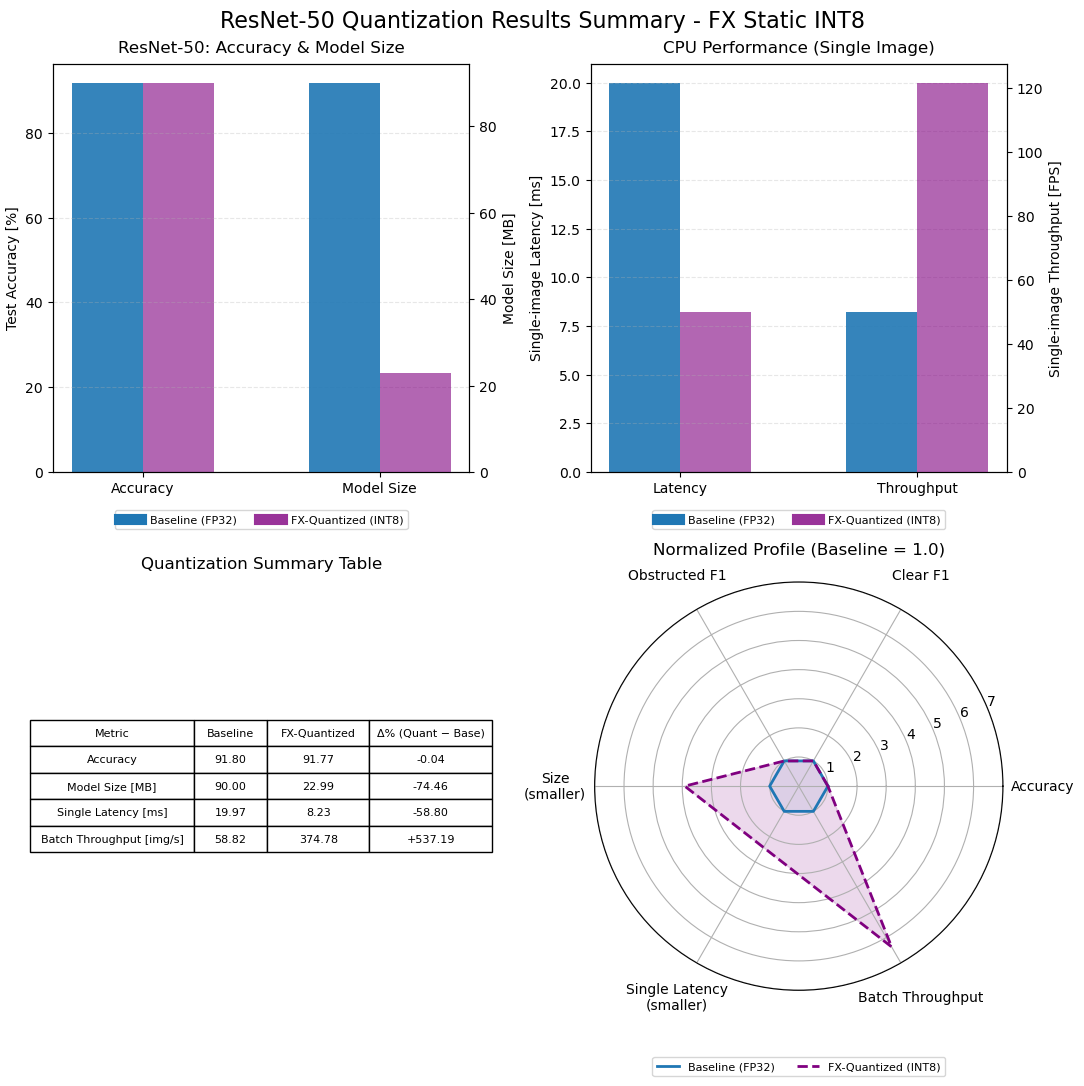

In [58]:
import numpy as np
import matplotlib.pyplot as plt

# -----------------------------
# Pull numbers (same as before)
# -----------------------------
acc_base   = float(acc_r50)
acc_quant  = float(acc_r50_quant_fx)

f1_clear_base  = float(metrics_r50["clear"][2])
f1_clear_quant = float(metrics_r50_quant_fx["clear"][2])
f1_obst_base   = float(metrics_r50["obstructed"][2])
f1_obst_quant  = float(metrics_r50_quant_fx["obstructed"][2])

size_base  = float(baseline_r50_size_mb)
size_quant = float(quant_r50_fx_size_mb)

single_lat_base  = float(r50_latency_stats["single_mean_ms"])
single_lat_quant = float(r50_quant_latency_stats["single_mean_ms"])
single_fps_base  = float(r50_latency_stats["single_fps"])
single_fps_quant = float(r50_quant_latency_stats["single_fps"])

batch_lat_base   = float(r50_latency_stats["batch_mean_ms"])
batch_lat_quant  = float(r50_quant_latency_stats["batch_mean_ms"])
batch_fps_base   = float(r50_latency_stats["batch_fps"])
batch_fps_quant  = float(r50_quant_latency_stats["batch_fps"])

def pct_change(new, old):
    return (new - old) / old * 100.0

# -----------------------------
# Figure & axes
# -----------------------------
fig = plt.figure(figsize=(11, 11))
fig.suptitle("ResNet-50 Quantization Results Summary - FX Static INT8", fontsize=16, y=0.98)
ax1 = fig.add_subplot(2, 2, 1)
ax2 = fig.add_subplot(2, 2, 2)
ax3 = fig.add_subplot(2, 2, 3)
ax4 = fig.add_subplot(2, 2, 4, projection='polar')

for ax in [ax1, ax2, ax3]:
    try:
        ax.set_box_aspect(1)
    except Exception:
        pass

baseline_color = "tab:blue"
quant_color    = "purple"
width = 0.3

# =======================================================
# Subplot 1 – Accuracy & Model Size (x = metrics)
# =======================================================
metrics1 = ["Accuracy", "Model Size"]
x = np.arange(len(metrics1))

ax1_left = ax1
ax1_right = ax1_left.twinx()

# Bars for Baseline / Quant – Accuracy (left axis)
acc_x = x[0]
ax1_left.bar(acc_x - width/2,
             acc_base * 100,
             width,
             color=baseline_color,
             alpha=0.9)
ax1_left.bar(acc_x + width/2,
             acc_quant * 100,
             width,
             color=quant_color,
             alpha=0.6)

# Bars for Baseline / Quant – Model Size (right axis)
size_x = x[1]
ax1_right.bar(size_x - width/2,
              size_base,
              width,
              color=baseline_color,
              alpha=0.9)
ax1_right.bar(size_x + width/2,
              size_quant,
              width,
              color=quant_color,
              alpha=0.6)

ax1_left.set_xticks(x)
ax1_left.set_xticklabels(metrics1)
ax1_left.set_ylabel("Test Accuracy [%]")
ax1_right.set_ylabel("Model Size [MB]")
ax1_left.set_title("ResNet-50: Accuracy & Model Size", pad=8)
ax1_left.grid(axis="y", linestyle="--", alpha=0.3)

# Legend: Baseline vs Quantized
handles1 = [
    plt.Line2D([0], [0], color=baseline_color, lw=8, label="Baseline (FP32)"),
    plt.Line2D([0], [0], color=quant_color, lw=8, alpha=0.8, label="FX-Quantized (INT8)"),
]
ax1_left.legend(handles=handles1,
                loc="upper center",
                bbox_to_anchor=(0.5, -0.08),
                ncol=2,
                fontsize=8)

# =======================================================
# Subplot 2 – Latency & Throughput (x = metrics)
# =======================================================
metrics2 = ["Latency", "Throughput"]
x2 = np.arange(len(metrics2))

ax2_left = ax2
ax2_right = ax2_left.twinx()

# Latency bars (left axis) at "Latency"
lat_x = x2[0]
ax2_left.bar(lat_x - width/2,
             single_lat_base,
             width,
             color=baseline_color,
             alpha=0.9)
ax2_left.bar(lat_x + width/2,
             single_lat_quant,
             width,
             color=quant_color,
             alpha=0.6)

# Throughput bars (right axis) at "Throughput"
thr_x = x2[1]
ax2_right.bar(thr_x - width/2,
              single_fps_base,
              width,
              color=baseline_color,
              alpha=0.9)
ax2_right.bar(thr_x + width/2,
              single_fps_quant,
              width,
              color=quant_color,
              alpha=0.6)

ax2_left.set_xticks(x2)
ax2_left.set_xticklabels(metrics2)
ax2_left.set_ylabel("Single-image Latency [ms]")
ax2_right.set_ylabel("Single-image Throughput [FPS]")
ax2_left.set_title("CPU Performance (Single Image)", pad=8)
ax2_left.grid(axis="y", linestyle="--", alpha=0.3)

handles2 = [
    plt.Line2D([0], [0], color=baseline_color, lw=8, label="Baseline (FP32)"),
    plt.Line2D([0], [0], color=quant_color, lw=8, alpha=0.8, label="FX-Quantized (INT8)"),
]
ax2_left.legend(handles=handles2,
                loc="upper center",
                bbox_to_anchor=(0.5, -0.08),
                ncol=2,
                fontsize=8)

# =======================================================
# Subplot 3 – Summary table (slightly larger)
# =======================================================
ax3.axis("off")

table_data = [
    ["Accuracy",
     f"{acc_base*100:.2f}", f"{acc_quant*100:.2f}",
     f"{pct_change(acc_quant, acc_base):+.2f}"],
    ["Model Size [MB]",
     f"{size_base:.2f}", f"{size_quant:.2f}",
     f"{pct_change(size_quant, size_base):+.2f}"],
    ["Single Latency [ms]",
     f"{single_lat_base:.2f}", f"{single_lat_quant:.2f}",
     f"{pct_change(single_lat_quant, single_lat_base):+.2f}"],
    ["Batch Throughput [img/s]",
     f"{batch_fps_base:.2f}", f"{batch_fps_quant:.2f}",
     f"{pct_change(batch_fps_quant, batch_fps_base):+.2f}"],
]

col_labels = ["Metric", "Baseline", "FX-Quantized", "Δ% (Quant − Base)"]
col_widths = [0.40, 0.18, 0.25, 0.30]

table = ax3.table(cellText=table_data,
                  colLabels=col_labels,
                  loc="center",
                  cellLoc="center",
                  colWidths=col_widths)

table.auto_set_font_size(False)
table.set_fontsize(8)
table.scale(1.0, 1.5)  # slightly larger than before
ax3.set_title("Quantization Summary Table", pad=10)

# =======================================================
# Subplot 4 – Radar / Spider
# =======================================================
radar_labels = [
    "Accuracy",
    "Clear F1",
    "Obstructed F1",
    "Size\n(smaller)",
    "Single Latency\n(smaller)",
    "Batch Throughput"
]

baseline_radar = np.ones(len(radar_labels))
quant_radar = np.array([
    acc_quant / acc_base,
    f1_clear_quant / f1_clear_base,
    f1_obst_quant / f1_obst_base,
    size_base / size_quant,
    single_lat_base / single_lat_quant,
    batch_fps_quant / batch_fps_base,
])

angles = np.linspace(0, 2*np.pi, len(radar_labels), endpoint=False)
angles = np.concatenate([angles, angles[:1]])
baseline_plot = np.concatenate([baseline_radar, baseline_radar[:1]])
quant_plot    = np.concatenate([quant_radar,   quant_radar[:1]])

ax4.plot(angles, baseline_plot, linewidth=2, color=baseline_color,
         label="Baseline (FP32)")
ax4.fill(angles, baseline_plot, alpha=0.08, color=baseline_color)

ax4.plot(angles, quant_plot, linewidth=2, linestyle="--", color=quant_color,
         label="FX-Quantized (INT8)")
ax4.fill(angles, quant_plot, alpha=0.15, color=quant_color)

ax4.set_xticks(angles[:-1])
ax4.set_xticklabels(radar_labels)
ax4.set_ylim(0, max(1.2, quant_radar.max() * 1.1))
ax4.set_title("Normalized Profile (Baseline = 1.0)", pad=20)
ax4.tick_params(axis='x', pad=18)
ax4.set_aspect('equal', adjustable='box')

ax4.legend(loc="upper center",
           bbox_to_anchor=(0.5, -0.15),
           ncol=2,
           fontsize=8)

plt.tight_layout()
plt.show()


In [59]:
import torch

# ResNet50 quantized full module
torch.save(r50_quant_fx, "resnet50_clear_obstructed_quant_fx_full.pt")

print("Saved full quantized ResNet50 module.")

Saved full quantized ResNet50 module.
